In [ ]:
import numpy as np


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

class SVM:
    def __init__(self, kernel='linear', C=1.0, learning_rate=0.001, lambda_param=0.01, n_iters=1000, method='gradient'):
        self.kernel = kernel
        self.C = C
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.method = method  # 'gradient' or 'lagrange'
        self.w = None
        self.b = None
        self.alphas = None
        self.sv = None
        self.sv_labels = None

    def _kernel_function(self, x, y):
        if self.kernel == 'linear':
            return np.dot(x, y)
        elif self.kernel == 'polynomial':
            return (np.dot(x, y) + 1) ** 3  # Degree 3 polynomial
        elif self.kernel == 'rbf':
            gamma = 0.1
            return np.exp(-gamma * np.linalg.norm(x - y) ** 2)
        else:
            raise ValueError("Unsupported kernel")

    def fit(self, X, y):
        y_ = np.where(y <= 0, -1, 1)
        if self.method == 'gradient':
            self._fit_gradient(X, y_)
        elif self.method == 'lagrange':
            self._fit_lagrange(X, y_)
        else:
            raise ValueError("Unknown method")

    def _fit_gradient(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]

    def _fit_lagrange(self, X, y):
        n_samples, n_features = X.shape
        K = np.array([[self._kernel_function(X[i], X[j]) for j in range(n_samples)] for i in range(n_samples)])

        P = (y[:, None] * y) * K
        q = -np.ones(n_samples)
        alphas = np.zeros(n_samples)

        for _ in range(self.n_iters):
            gradient = np.dot(P, alphas) + q
            alphas -= self.lr * gradient
            alphas = np.clip(alphas, 0, self.C)

        sv = (alphas > 1e-5) & (alphas < self.C)
        self.sv = X[sv]
        self.sv_labels = y[sv]
        self.alphas = alphas[sv]

        self.w = np.sum(self.alphas[:, None] * self.sv_labels[:, None] * self.sv, axis=0)

        support_vector_indices = np.where(sv)[0]
        self.b = np.mean([y[i] - np.dot(self.w, X[i]) for i in support_vector_indices])



    def predict(self, X):
        if self.method == 'gradient':
            return np.sign(np.dot(X, self.w) - self.b)
        else:
            return np.sign(np.array([np.sum(self.alphas * self.sv_labels *
                                            np.array([self._kernel_function(sv, x) for sv in self.sv])) + self.b for x in X]))

    def accuracy(self, y_pred, y_test):
        return np.mean(y_pred == y_test)

    def visualize(self, X, y):
        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(X[:, 0], X[:, 1], marker='o', c=y)

        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])
        x1_1 = get_hyperplane_value(x0_1, self.w, self.b, 0)
        x1_2 = get_hyperplane_value(x0_2, self.w, self.b, 0)
        x1_3 = get_hyperplane_value(x0_1, self.w, self.b, -1)
        x1_4 = get_hyperplane_value(x0_2, self.w, self.b, -1)
        x1_5 = get_hyperplane_value(x0_1, self.w, self.b, 1)
        x1_6 = get_hyperplane_value(x0_2, self.w, self.b, 1)

        ax.plot([x0_1, x0_2], [x1_1, x1_2], 'y')
        ax.plot([x0_1, x0_2], [x1_3, x1_4], 'g--')
        ax.plot([x0_1, x0_2], [x1_5, x1_6], 'r--')
        plt.show()


Training using Gradient Descent and Linear kernel...
Gradient Descent Accuracy: 1.0


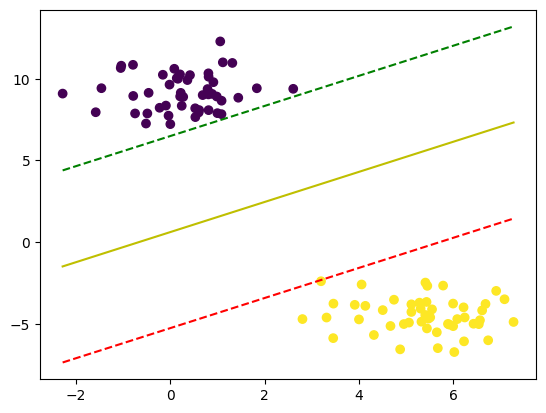

Training using Lagrange Multipliers and Linear Kernel...
Lagrange Multipliers Accuracy: 1.0


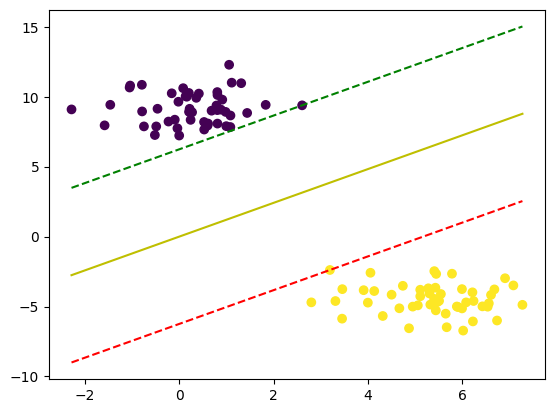

Training using Gradient Descent and polynomial kernel ...
Gradient Descent Accuracy: 1.0


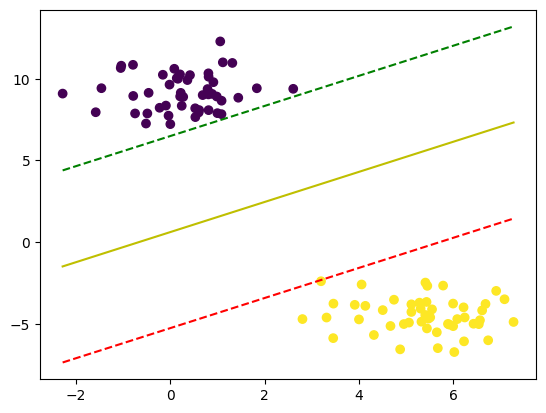

Training using Lagrange Multipliers and polynomial kernel...
Lagrange Multipliers Accuracy: 0.0


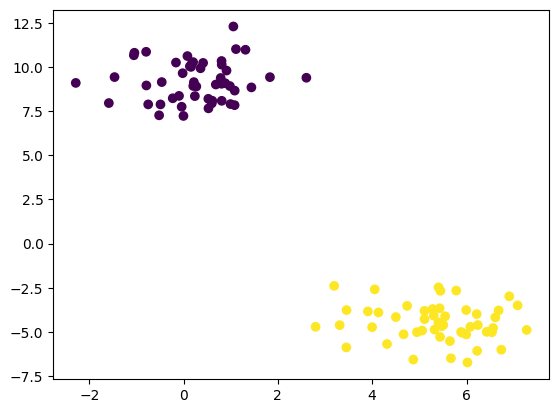

Training using Gradient Descent and rbf kernel...
Gradient Descent Accuracy: 1.0


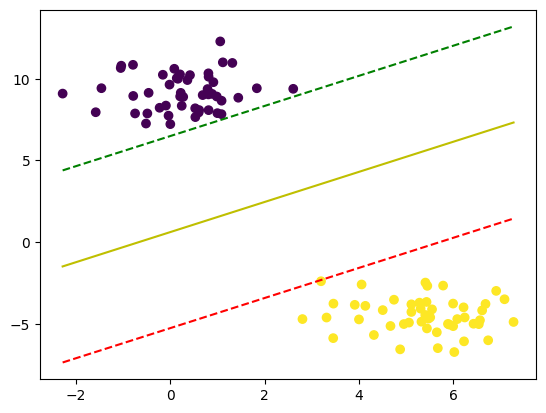

Training using Lagrange Multipliers and rbf kernel ...
Lagrange Multipliers Accuracy: 0.6


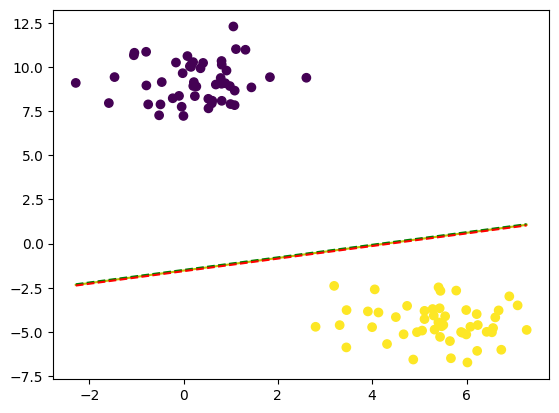

In [ ]:

if __name__ == "__main__":
    X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.05, random_state=23)
    y = np.where(y == 0, -1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

    print("Training using Gradient Descent and Linear kernel...")
    clf_gd = SVM(kernel='linear', method='gradient')
    clf_gd.fit(X_train, y_train)
    acc_gd = clf_gd.accuracy(clf_gd.predict(X_test), y_test)
    print(f"Gradient Descent Accuracy: {acc_gd}")
    clf_gd.visualize(X,y)

    print("Training using Lagrange Multipliers and Linear Kernel...")
    clf_lag = SVM(kernel='linear', method='lagrange')
    clf_lag.fit(X_train, y_train)
    acc_lag = clf_lag.accuracy(clf_lag.predict(X_test), y_test)
    print(f"Lagrange Multipliers Accuracy: {acc_lag}")
    clf_lag.visualize(X,y)

    print("Training using Gradient Descent and polynomial kernel ...")
    clf_gd = SVM(kernel='polynomial', method='gradient')
    clf_gd.fit(X_train, y_train)
    acc_gd = clf_gd.accuracy(clf_gd.predict(X_test), y_test)
    print(f"Gradient Descent Accuracy: {acc_gd}")
    clf_gd.visualize(X,y)

    print("Training using Lagrange Multipliers and polynomial kernel...")
    clf_lag = SVM(kernel='polynomial', method='lagrange')
    clf_lag.fit(X_train, y_train)
    acc_lag = clf_lag.accuracy(clf_lag.predict(X_test), y_test)
    print(f"Lagrange Multipliers Accuracy: {acc_lag}")
    clf_lag.visualize(X,y)

    print("Training using Gradient Descent and rbf kernel...")
    clf_gd = SVM(kernel='rbf', method='gradient')
    clf_gd.fit(X_train, y_train)
    acc_gd = clf_gd.accuracy(clf_gd.predict(X_test), y_test)
    print(f"Gradient Descent Accuracy: {acc_gd}")
    clf_gd.visualize(X,y)

    print("Training using Lagrange Multipliers and rbf kernel ...")
    clf_lag = SVM(kernel='rbf', method='lagrange')
    clf_lag.fit(X_train, y_train)
    acc_lag = clf_lag.accuracy(clf_lag.predict(X_test), y_test)
    print(f"Lagrange Multipliers Accuracy: {acc_lag}")
    clf_lag.visualize(X,y)